# SIR model with vaccine

20160463 성해빈

In [1]:
# We will be using numpy and networkx for our function
import networkx as nx
import numpy as np

In [2]:
# There will be 5 parameters for the model:
# (graph) The networkx graph 
# (tmax) The maximum time that we will run the model 
# (beta) The infection probability 
# (gamma) The recover probability
# (zeta) The susceptible probability
# (initial_inf) The initial fraction of infected nodes
def SIRS_vaccine(graph, tmax, beta, gamma, zeta, initial_inf):
    # set random nodes to get infected
    inf_o = set(np.random.choice(graph.nodes(), size=int(len(graph) * initial_inf), replace=False))
    nx.set_node_attributes(graph, {node: ([1] if node in inf_o else [0]) for node in graph.nodes()},'inf')
    for t in range(tmax):
        # VACCINE : pick susceptible node that has the most possibility to get infected, change to recovered
        max_inf_neighbor_node, max_inf_neighbor_frac = None, None
        for node in graph.nodes():
            if graph.nodes[node]['inf'][t] == 0: # susceptible(0)
                num_inf_neighbors = np.sum([ graph.nodes[neighbor]['inf'][t] == 1 for neighbor in graph.neighbors(node)])
                frac_inf_neighbors = num_inf_neighbors / len(list(graph.neighbors(node)))
                if max_inf_neighbor_node == None:
                    max_inf_neighbor_frac = frac_inf_neighbors
                    max_inf_neighbor_node = node
                elif max_inf_neighbor_frac < frac_inf_neighbors:
                    max_inf_neighbor_frac = frac_inf_neighbors
                    max_inf_neighbor_node = node
        if max_inf_neighbor_node != None:
            graph.nodes[max_inf_neighbor_node]['inf'][t] = 2 # recovered(2)
        
        for node in graph.nodes():
            if graph.nodes[node]['inf'][t] == 0: # susceptible(0)
                # First determine how many infected neighbors the node has at time t:
                neighbors = list(graph.neighbors(node))
                num_inf_neighbors = np.sum([ graph.nodes[neighbor]['inf'][t] == 1 for neighbor in neighbors])

                if np.random.random() < num_inf_neighbors / len(neighbors) * beta:
                    # If infection occurs we add a 1 to the state list of the node.
                    # Note that by doing this we don't change how the other 
                    # nodes update, because they will be using time index t not t+1
                    graph.nodes[node]['inf'].append(1)
                else:
                    # If no infection occurs, then just append the current state
                    graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
                    
            # if the node is already infected it can heal by probability gamma
            elif graph.nodes[node]['inf'][t] == 1: # infectious(1)
                if np.random.random() < gamma:
                    # heal
                    graph.nodes[node]['inf'].append(2) # recovered(2)
                else:
                    # no heal, just append current state
                    graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
            else: # recovered(2)
                if np.random.random() < zeta:
                    graph.nodes[node]['inf'].append(0) # susceptible(0)
                else:
                    # just append current state
                    graph.nodes[node]['inf'].append(graph.nodes[node]['inf'][t])
                
                
    # Once the updates have run their course for all nodes up to tmax we can
    # return the time-series of the fraction of susceptible, infectious, recovered nodes
    return [ np.sum([ graph.nodes[node]['inf'][t] == 0 for node in graph.nodes() ]) / len(graph.nodes()) for t in range(tmax)], \
        [ np.sum([ graph.nodes[node]['inf'][t] == 1 for node in graph.nodes() ]) / len(graph.nodes()) for t in range(tmax)], \
        [ np.sum([ graph.nodes[node]['inf'][t] == 2 for node in graph.nodes() ]) / len(graph.nodes()) for t in range(tmax)]

In [3]:
# Now lets plot it
%matplotlib inline
import matplotlib.pyplot as plt

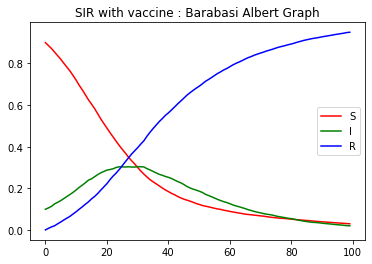

In [4]:
ba_graph = nx.barabasi_albert_graph(1000, 53)

sample_run = 10
time = 100
sample_mean = np.mean([SIRS_vaccine(ba_graph, tmax=time, beta=0.152, gamma=0.053, zeta=0, initial_inf=0.1) for i in range(sample_run)], axis=0)
plt.title("SIR with vaccine : Barabasi Albert Graph")
plt.plot(sample_mean[0], label="S", color="red")
plt.plot(sample_mean[1], label="I", color="green")
plt.plot(sample_mean[2], label="R", color="blue")
plt.legend()